# First look at the data

In [85]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import io_utils as iu
from importlib import reload
reload(iu)

%matplotlib inline

In [86]:
# A single data set:
participant = 'Subject1'

eeg, mastoids = iu.load_one_subject(participant)

In [35]:
word_dict = {}
for i in word_list:
    if i in word_dict.keys():
        word_dict[i] += 1
    else:
        word_dict[i] = 1

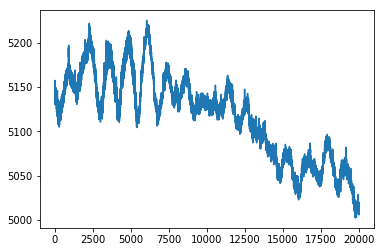

In [76]:
plt.plot(EEG['eegData'][:20000, 110])